In [1]:
import numpy as np
import xarray as xr
from xgcm import Grid
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, zoomed_inset_axes
import dask
import cmocean
from glob import glob
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

%matplotlib inline

## Start cluster

In [2]:
#uncomment if working on cluster

# from distributed import Client, progress, LocalCluster
# import socket

# client = Client(service_kwargs={'dashboard': {'prefix': f'/node/{socket.gethostname()}/8787'}})

In [3]:
#uncomment if working on cluster

#client

In [4]:
# uncomment if working on cluster

# filelist=[]
# for files in glob('/srv/scratch/z3533156/20year_run_tide/outer_dia/outer_dia_0[1-9]*.nc'): 
#     #print(files)
#     filelist.append(files)

# # A basic chunk choice
# chunks = {'ocean_time':1}

# diag = xr.open_mfdataset(filelist, chunks=chunks, data_vars='minimal',compat='override',coords='minimal',parallel=True)

# filelist=[]
# for files in glob('/srv/scratch/z3533156/20year_run_tide/outer_avg/outer_avg_0[1-9]*.nc'): 
#     filelist.append(files)

# ds = xr.open_mfdataset(filelist, chunks=chunks, data_vars='minimal',compat='override',coords='minimal',parallel=True)

In [5]:
ds=xr.open_dataset('../../outer_avg_01461.nc')

## Creating a grid object
While xgcm doesn't currently have an implementation for the SGRID convention for ROMS, a workaround consist on renaming eta_u and xi_v dimensions to rho. With this replacement 'psi' points have now a position (eta_v, xi_u). See issue here https://github.com/xgcm/xgcm/issues/108
Here I also test to see if the new XGCM 'metrics' functionality works.

In [6]:
# Including metrics
ds = ds.rename({'eta_u': 'eta_rho', 'xi_v': 'xi_rho', 'xi_psi': 'xi_u', 'eta_psi': 'eta_v'})

coords={'X':{'center':'xi_rho', 'inner':'xi_u'}, 
    'Y':{'center':'eta_rho', 'inner':'eta_v'}, 
    'Z':{'center':'s_rho', 'outer':'s_w'}}

grid = Grid(ds, coords=coords, periodic=[])

Zo_rho = (ds.hc * ds.s_rho + ds.Cs_r * ds.h) / (ds.hc + ds.h)
z_rho = Zo_rho * (ds.zeta + ds.h) + ds.zeta
Zo_w = (ds.hc * ds.s_w + ds.Cs_w * ds.h) / (ds.hc + ds.h)
z_w = Zo_w * (ds.zeta + ds.h) + ds.zeta

ds.coords['z_w'] = z_w.where(ds.mask_rho, 0).transpose('ocean_time', 's_w', 'eta_rho', 'xi_rho')
ds.coords['z_rho'] = z_rho.where(ds.mask_rho, 0).transpose('ocean_time', 's_rho', 'eta_rho', 'xi_rho')


ds['pm_v'] = grid.interp(ds.pm, 'Y')
ds['pn_u'] = grid.interp(ds.pn, 'X')
ds['pm_u'] = grid.interp(ds.pm, 'X')
ds['pn_v'] = grid.interp(ds.pn, 'Y')
ds['pm_psi'] = grid.interp(grid.interp(ds.pm, 'Y'),  'X') # at psi points (eta_v, xi_u) 
ds['pn_psi'] = grid.interp(grid.interp(ds.pn, 'X'),  'Y') # at psi points (eta_v, xi_u)

ds['dx'] = 1/ds.pm
ds['dx_u'] = 1/ds.pm_u
ds['dx_v'] = 1/ds.pm_v
ds['dx_psi'] = 1/ds.pm_psi

ds['dy'] = 1/ds.pn
ds['dy_u'] = 1/ds.pn_u
ds['dy_v'] = 1/ds.pn_v
ds['dy_psi'] = 1/ds.pn_psi

ds['dz'] = grid.diff(ds.z_w, 'Z', boundary='fill')
ds['dz_w'] = grid.diff(ds.z_rho, 'Z', boundary='fill')
ds['dz_u'] = grid.interp(ds.dz, 'X')
ds['dz_w_u'] = grid.interp(ds.dz_w, 'X')
ds['dz_v'] = grid.interp(ds.dz, 'Y')
ds['dz_w_v'] = grid.interp(ds.dz_w, 'Y')

ds['dA'] = ds.dx * ds.dy

metrics = {
    ('X',): ['dx', 'dx_u', 'dx_v', 'dx_psi'], # X distances
    ('Y',): ['dy', 'dy_u', 'dy_v', 'dy_psi'], # Y distances
    ('Z',): ['dz', 'dz_u', 'dz_v', 'dz_w', 'dz_w_u', 'dz_w_v'], # Z distances
    ('X', 'Y'): ['dA'] # Areas
}
grid = Grid(ds, coords=coords, metrics=metrics, periodic=[])

## Calculate depth-averaged speed

In [7]:
def magnitude(a, b):
    func = lambda x, y: np.sqrt(x ** 2 + y ** 2)
    return xr.apply_ufunc(func, a, b, dask="parallelized")

### need to interp ubar and vbar onto common locations

In [8]:
ubar_rho = grid.interp(ds.u.isel(s_rho=-1),'X',boundary='fill')
vbar_rho = grid.interp(ds.v.isel(s_rho=-1),'Y',boundary='fill')

In [9]:
ds['speed_bar'] = magnitude(ubar_rho,vbar_rho)

In [10]:
# Choose day to plot
day = 10

# set up normalised vectors to show direction
X = ds.lon_rho
Y = ds.lat_rho

# normalise arrows to only show direction
U = (ubar_rho/ds.speed_bar).isel(ocean_time=day)
V = (vbar_rho/ds.speed_bar).isel(ocean_time=day)

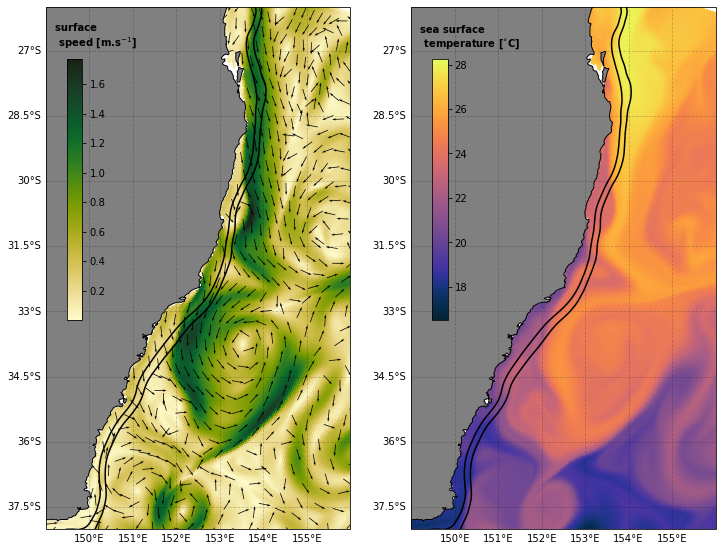

In [19]:
fig = plt.figure(figsize=(12,10))
#set coastline
coast = cfeature.NaturalEarthFeature(category='physical', scale='10m',
                            facecolor='none', name='coastline')

skip = (slice(None, None, 8), slice(None, None, 8))

#plot
ax = plt.subplot(1,2,1,projection=ccrs.PlateCarree())
feature = ax.add_feature(coast, edgecolor='black',facecolor='gray')
im=ds.speed_bar.isel(ocean_time=day).plot.pcolormesh('lon_rho', 'lat_rho',cmap=cmocean.cm.speed, ax=ax,add_colorbar=False)
ds.h.plot.contour('lon_rho', 'lat_rho', ax=ax, colors='black', levels=[200,1000])
Q = plt.quiver(X[skip], Y[skip], U[skip], V[skip], units='width', scale=25)
ax.set_extent([149,156,-26,-38])
#make pretty gridlines and labels
gl = ax.gridlines(draw_labels=True,
             color='black', alpha=0.2, linestyle='--')
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.right_labels = False
gl.top_labels = False
#label to tell what it is
plt.text(149.2,-26.9,'surface \n speed [m.s$^{-1}$]',weight='bold')

# colorbar
cax = inset_axes(ax,
                 width="5%",  # width = 10% of parent_bbox width
                 height="50%",  # height : 50%
                 loc='lower left',
                 bbox_to_anchor=(.07,.4, 1, 1),
                 bbox_transform=ax.transAxes,
                 borderpad=0,
                 )
fig.colorbar(im, cax=cax)

ax = plt.subplot(1,2,2,projection=ccrs.PlateCarree())
feature = ax.add_feature(coast, edgecolor='black',facecolor='gray')
im=ds.temp.isel(s_rho=-1,ocean_time=day).plot.pcolormesh('lon_rho', 'lat_rho',cmap=cmocean.cm.thermal, ax=ax,add_colorbar=False)

ds.h.plot.contour('lon_rho', 'lat_rho', ax=ax, colors='black', levels=[200,1000])
ax.set_extent([149,156,-26,-38])
#make pretty gridlines and labels
gl = ax.gridlines(draw_labels=True,
             color='black', alpha=0.2, linestyle='--')
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.right_labels = False
gl.top_labels = False
#label to tell what it is
plt.text(149.2,-26.9,'sea surface \n temperature [$^{\circ}$C]',weight='bold')

# colorbar
cax = inset_axes(ax,
                 width="5%",  # width = 10% of parent_bbox width
                 height="50%",  # height : 50%
                 loc='lower left',
                 bbox_to_anchor=(.07,.4, 1, 1),
                 bbox_transform=ax.transAxes,
                 borderpad=0,
                 )
fig.colorbar(im, cax=cax)

plt.savefig('Figures/speed_surf.png', dpi=300)

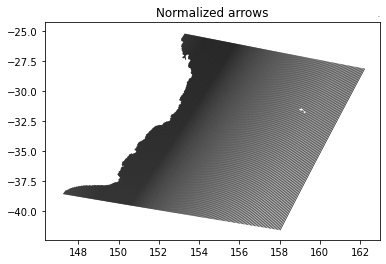

In [13]:
X = ds.lon_rho
Y = ds.lat_rho

# normalise arrows to only show direction
U = (ubar_rho/ds.speed_bar).isel(ocean_time=10)
V = (vbar_rho/ds.speed_bar).isel(ocean_time=10)

plt.figure()
plt.title('Normalized arrows')
Q = plt.quiver(X, Y, U, V, units='width')
qk = plt.quiverkey(Q, 0.9, 0.9, 2, r'$2 \frac{m}{s}$', labelpos='E',
                   coordinates='figure')